In [1]:
%matplotlib inline
from sensible_raw.loaders import loader
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from collections import defaultdict, Counter
from datetime import datetime as dt
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import scale
from sklearn.tree import export_graphviz
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cd ..

/home/ulf/build_dataset


In [3]:
from workers import load_sensible_data as lsd
from workers import apply_time_constraints as atc

from workers import location_is_dorm as lid
from workers import location_is_campus as lic

In [4]:
tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]} #in school

df_stop_locations = lsd.load(tc0['spans'], "stop_locations")
df_stop_locations = atc.apply(df_stop_locations, tc0).sort(["timestamp"], ascending=True)

t0 = list(df_stop_locations['timestamp'])[0]/1000
tt = list(df_stop_locations['timestamp'])[-1]/1000

users = set(df_stop_locations['user'])

<2014> jan feb mar apr may jun sep oct nov dec


In [121]:
"""
Take the location which is not a Campus, has the largest std 
in time and has time mean closest to 00:00:00.
"""

def timezone_offset(longitude):
    return np.floor((longitude+7.5)/15)


def compute_states(df_u):
    """
    Returns
    -------
    states : json
    
        Example
        -------
        {0: [{'arrival': 1409669100.0,
              'coordinates': (32.776401774999997, -117.069998025),
              'duration': 6300.0},
             {'arrival': 1409697000.0,
              'coordinates': (32.777439200000003, -117.0703111),
              'duration': 5400.0},
              ...],
         1: [{'arrival': 1409669100.0,
              'coordinates': (32.776401774999997, -117.069998025),
              'duration': 6300.0},
             {'arrival': 1409697000.0,
              'coordinates': (32.777439200000003, -117.0703111),
              'duration': 5400.0},
            ...
            ],
        ...
        }  
    """
    states = defaultdict(list)
    for row in df_u.iterrows():
        coordina = (row[1]['lat'], row[1]['lon'])
        time_offset = timezone_offset(coordina[1])
        
        loclabel = row[1]['label']
        arrivalt = row[1]['arrival']+3600*time_offset
        duration = row[1]['delta']
        
        states[loclabel].append({'arrival': arrivalt, 
                                 'duration': duration, 
                                 'coordinates': coordina})
    return states
    
def bin_24(start, duration):
    """Bin time-span to 24 buckets, 1 for each hour of the day.
    """
    bins = [(1+h)*3600 for h in range(24)]
    vals = [x%86400 for x in xrange(int(start),int(start+duration),1)]
    hist = Counter(np.digitize(vals,bins))
    for i in range(24):
        if i not in hist:
            hist[i] = 0
    return hist


def home_mean_diff(time_dist,home_mean=1.5):
    """Compute abs difference between circular mean time
    at given location and mean of circular mean times across
    all locations deemed home (simple criteria and loc=dorm).
    
    Source of computation for circular mean: 
    http://www.smipple.net/snippet/ptweir/circular%20mean%20and%20variance
    
    Return
    ------
    to_hou(cmean) : float
        The circularly average hour of that state
    """
    to_rad = lambda x: x*2*np.pi/24.0
    to_hou = lambda x: x*24.0/(2*np.pi)
    sinsum = 0
    cossum = 0
    for k,v in time_dist.items():
        sinsum += v*np.sin(to_rad(k))
        cossum += v*np.cos(to_rad(k))
    count = sum(time_dist.values())
    cmean = np.arctan2(sinsum*1.0/count,cossum*1.0/count)
    if cmean < 0: cmean = 2*np.pi + cmean
    cmean_hour = to_hou(cmean)
    if cmean_hour < (12+home_mean):
        return abs(cmean_hour-home_mean)
    else:
        return 24+home_mean - cmean_hour


def spread(timestamps, timerange):
    """Measures what fraction of days in its span, this location was visited"""
    bins = range(timerange/86400+1)
    vals = (np.array(timestamps)-timestamps[0])/86400
    hist = Counter(np.digitize(vals,bins))
    
    return len(hist) * 1.0 / len(bins)

def is_home_location(state_point):
    if state_point['hmdiff'] > 4: return 0
    if state_point['spread'] < 0.2: return 0
    if state_point['timespent'] < 0.15: return 0
    if state_point['span'] < 20: return 0
    return 1


ds = dict()

for u in users:
    if u <= max(ds.keys()): continue
    # get user stops and summed stops duration
    df_u = df_stop_locations[df_stop_locations['user'] == u]
    df_u['delta'] = df_u['departure'] - df_u['arrival']
    u_sum_t = sum(df_u['delta'])
    u_t0 = sorted(list(df_u['arrival']))[0]
    u_tt = sorted(list(df_u['departure']))[-1]
    
    # aggregate state events
    states = compute_states(df_u)
    
    # compute summary statistics for sttes
    u_states = dict()
    for state, obs_list in states.items():
        #if len(obs_list) == 1: continue
        time_dist = defaultdict(int)
        time_spent = 0
        timestamps_arr = []
        timestamps_dep = []
        loca_dist = []
        for obs in obs_list:
            # time
            obs_time_dist = bin_24(obs['arrival'], obs['duration'])
            for (k,v) in obs_time_dist.items():
                time_dist[k] += v*1.0/u_sum_t
            loca_dist.append(obs['coordinates'])
            timestamps_arr.append(obs['arrival'])
            timestamps_dep.append(obs['arrival']+obs['duration'])
            time_spent += obs['duration']
        
        loca_center = np.mean(zip(*loca_dist),axis=1)
        span_s = max(timestamps_dep)-min(timestamps_arr)
        
        state_point = {'hmdiff': home_mean_diff(time_dist),
                       'spread': spread(timestamps_arr, int(span_s)),
                       'span': (span_s)/86400,
                       'timespent': time_spent/(span_s),
                       'campus': lic.validate(loca_center),
                       'dorm': lid.validate(loca_center),
                       'loca_center': loca_center}
        
        state_point['y'] = is_home_location(state_point)

        u_states[state] = state_point

    ds[u] = u_states
    
    if u%5 == 0:
        print u,
    
                

In [122]:
num_features = ["hmdiff","spread","timespent", "span"]
nnu_features = ["campus", "dorm"]
ref_list = []

featurenames = ["Time diff. from home mean time", "Fraction of days visited", 
                "Fraction of time spent at loc.", "Span of days visited"]

X_num, X_nnu = [], []
for u, states in ds.items():
    for s, vals in states.items():
        ref_list.append((u,s))
        X_num.append([float(vals[f]) for f in num_features])
        X_nnu.append([bool(vals[f]) for f in nnu_features])
        
X_num = np.array(X_num)
X_nnu = np.array(X_nnu)

In [1052]:
#clf = DecisionTreeClassifier(random_state=0)
#clf.fit(X_t,Y_t)
#Y_p = clf.predict(X_o)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best')

In [1070]:
#b = (set(np.where(Y_p == 1)[0]) & set(np.where(Y_o == -1)[0]))
#print "-1 classified as 1:\t", len(b)
#print "total classified as 1:\t", len(np.where(Y_p == 1)[0])
#print
#print "%s\t%s\t%s" % (features[0],features[1],features[2])
#for i in b:
#    a = list(X_o[i,:])
#    print "%.2f\t%.2f\t%.2f" % (a[0],a[1],a[2])

-1 classified as 1:	279
total classified as 1:	430

hmdiff	spread	timespent
1.64	0.81	0.40
0.03	0.75	0.59
0.90	0.63	0.49
0.24	0.75	0.52
0.26	0.43	0.70
2.32	0.64	0.62
2.09	0.52	0.39
2.00	0.43	0.40
0.03	0.70	0.51
0.18	0.70	0.55
1.71	0.57	0.61
0.33	0.43	0.61
0.80	0.64	0.44
0.23	0.50	0.37
0.90	0.63	0.42
1.11	0.78	0.50
0.56	0.65	0.35
1.71	0.56	0.45
1.52	0.56	0.45
0.07	0.67	0.47
0.14	0.67	0.41
0.82	0.63	0.52
0.01	0.58	0.40
0.14	0.49	0.36
1.90	0.52	0.49
0.70	0.49	0.33
2.10	0.54	0.39
1.33	0.51	0.41
1.97	0.76	0.38
0.48	0.46	0.30
1.77	0.66	0.42
0.57	0.71	0.49
1.34	0.91	0.51
1.40	0.94	0.51
1.63	0.44	0.46
0.40	0.53	0.33
1.05	0.46	0.37
1.40	0.49	0.31
1.65	0.72	0.72
0.17	0.57	0.45
0.51	0.46	0.57
1.26	0.60	0.45
0.05	0.48	0.46
0.86	0.71	0.45
0.59	0.47	0.33
2.22	0.55	0.52
1.99	0.42	0.44
1.04	0.77	0.40
0.97	0.47	0.38
0.90	0.61	0.37
1.23	0.70	0.47
0.58	0.44	0.36
0.05	0.68	0.56
1.42	0.69	0.57
1.16	0.48	0.44
0.75	0.58	0.56
0.08	0.54	0.38
1.04	0.43	0.33
2.28	0.74	0.42
0.25	0.52	0.39
0.39	0.67	0.59
0.14	0.55

In [1133]:
#export_graphviz(clf, out_file='tree.dot')       

explained variance ratio (first two components): [ 0.63718269  0.25027196]


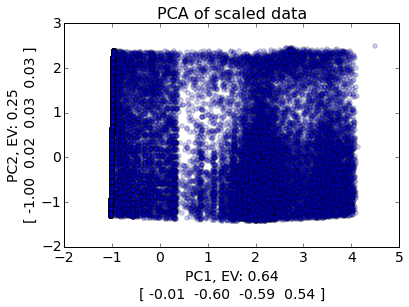

In [124]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = scale(X_num)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=0.2)
plt.xlabel("PC1, EV: %.02f\n[ %.02f  %.02f  %.02f  %.02f ]" % 
           (pca.explained_variance_ratio_[0],pca.components_[0][0],pca.components_[0][1],pca.components_[0][2],pca.components_[0][3])
           ,fontsize=14); 
plt.ylabel("PC2, EV: %.02f\n[ %.02f  %.02f  %.02f  %.02f ]" % 
           (pca.explained_variance_ratio_[1],pca.components_[1][0],pca.components_[1][1],pca.components_[1][2],pca.components_[1][3])
           ,fontsize=14); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title("PCA of scaled data" ,fontsize=16)
#plt.legend()

plt.show()

In [125]:
print num_features
print pca.components_

['hmdiff', 'spread', 'timespent', 'span']
[[-0.01290632 -0.60370591 -0.58854519  0.53757526]
 [-0.99884312  0.0234989   0.02707407  0.03205012]]


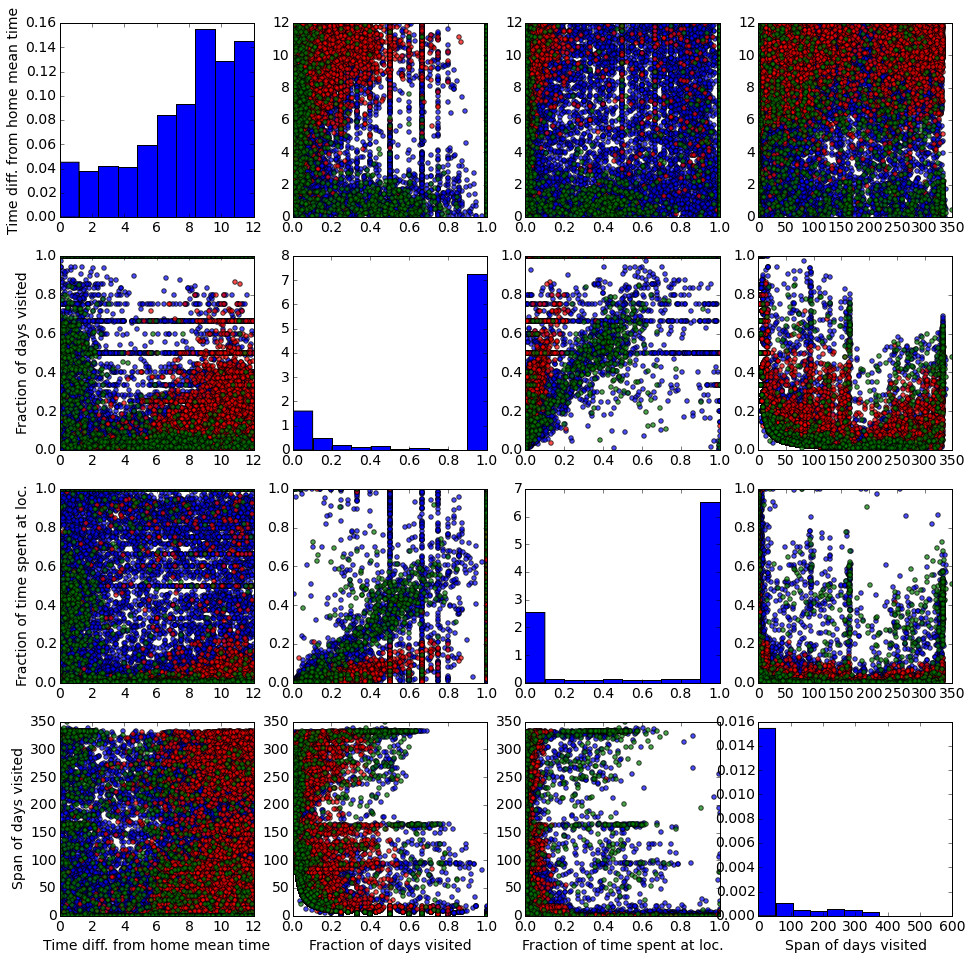

In [126]:
Y = X_nnu[:,1]
ranges = [[0,12],[0,1],[0,1],[0,350]]

M = X_num.shape[1]
plt.figure(figsize=(16,16))
c = 0
for i in range(M):
    for j in range(M):
        c+=1
        plt.subplot(M,M,c)
        if i == j:
            plt.hist(X_num[:, i],bins=10,normed=True)
            if j == 0:
                plt.ylabel(featurenames[i], fontsize=14)
            if i == M-1:
                plt.xlabel(featurenames[j], fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
        else:
            Y = X_nnu[:,0]+X_nnu[:,1]
            plt.scatter(X_num[Y == False, j], X_num[Y == False, i], c="b", alpha=0.7)
            Y = X_nnu[:,0]
            plt.scatter(X_num[Y == True, j], X_num[Y == True, i], c="r", alpha=0.7)
            Y = X_nnu[:,1]
            plt.scatter(X_num[Y == True, j], X_num[Y == True, i], c="g", alpha=0.7)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            if j == 0:
                plt.ylabel(featurenames[i], fontsize=14)
            if i == M-1:
                plt.xlabel(featurenames[j], fontsize=14)
            plt.xlim(ranges[j])
            plt.ylim(ranges[i])
            

In [141]:
Y = []
for i, _ in enumerate(X_nnu[:,0]):
    if X_nnu[i,1]:
        Y.append('Dorm')
    elif X_nnu[i,0]:
        Y.append('Campus')
    else:
        Y.append('Other')
        
Y = np.mat(Y).T

In [147]:
pd.DataFrame(np.hstack((scale(X_num),Y))).to_csv('locations.csv', index=False)

In [152]:
np.max(scale(X_num)[:,1])

0.59815189136876434

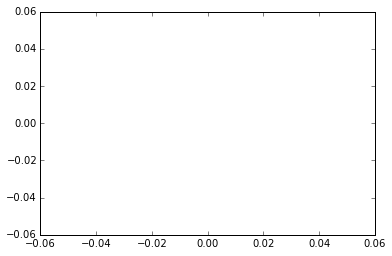

In [80]:
plt.figure()
plt.scatter(X_num[Y == k, i], X_num[Y == k, j], c=col, alpha=0.2)

In [83]:
Y

array([ 1.04661819, -1.69467861,  0.03507157,  0.92044557,  0.62532091,
       -0.70274009, -2.06551413, -1.25151445,  1.00866214,  0.45134779,
        0.23437024,  1.20739419, -1.51141688,  0.62532091,  1.06800791,
        0.06047331,  0.03507157,  0.33019624,  0.22977694,  1.09768324,
        0.84288035, -2.1011748 ,  0.92044557, -2.15419791,  0.33019624,
        0.03507157, -1.86185225, -0.48864424,  0.33019624,  1.06800791,
       -2.0308011 ,  0.27068071,  1.21557024, -1.80977501,  0.33019624,
       -1.79782948, -1.1454271 , -1.1454271 , -1.90443783, -1.44055176,
        1.21557024, -0.26005309,  0.92044557, -1.73567643,  0.92044557,
       -0.55517776,  1.21557024,  0.77288324,  1.1884635 ,  0.05691599,
       -0.16192936, -0.44197638, -1.44055176,  1.11515094,  0.92044557,
       -0.55517776, -0.7326938 ,  1.24860463, -1.1454271 ,  0.62532091,
       -0.18658934,  1.280917  ,  0.92044557,  0.62532091,  0.62532091,
        1.33483009,  0.03507157,  0.03507157,  1.21557024,  0.33

In [67]:
X_num[:,0]

array([ 13.0724769 ,  22.36108305,  16.5       ,  13.5       ,
        14.5       ,  19.        ,  24.38237842,  20.85946624,
        13.20108713,  15.08949027,  15.82469669,  12.52770373,
        21.74011926,  14.5       ,  13.        ,  16.41392879,
        16.5       ,  15.5       ,  15.84026062,  12.89944813,
        13.76282189,  24.26154584,  13.5       ,  24.08188242,
        15.5       ,  16.5       ,  25.07246602,  18.27455792,
        15.5       ,  13.        ,  24.5       ,  15.70166233,
        12.5       ,  25.24892448,  15.5       ,  22.71059931,
        20.5       ,  20.5       ,  23.07183089,  21.5       ,
        12.5       ,  17.5       ,  13.5       ,  25.5       ,
        13.5       ,  18.5       ,  12.5       ,  14.        ,
        12.59184845,  16.42598243,  17.16751768,  18.1164286 ,
        21.5       ,  12.84026062,  13.5       ,  18.5       ,
        19.10149509,  12.38806631,  20.5       ,  14.5       ,
        17.25107552,  12.27857912,  13.5       ,  14.5 

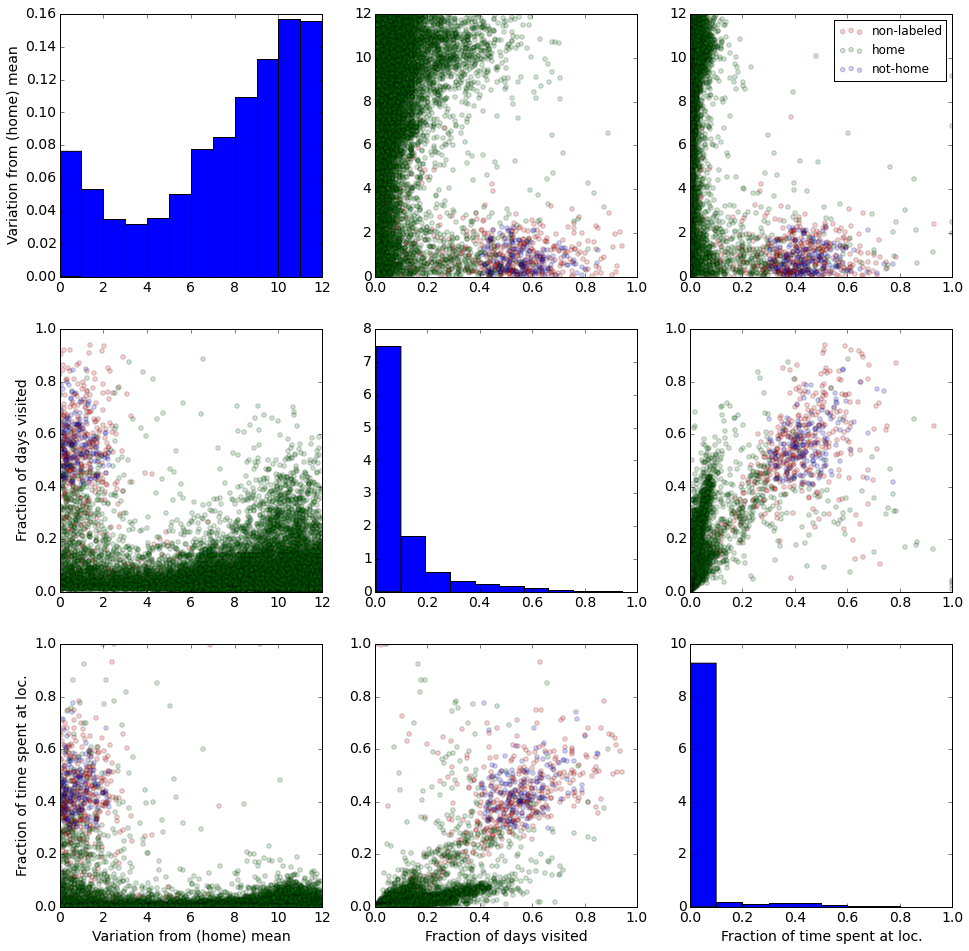

In [1137]:
plt.figure(figsize=(16,16))
plt.title("Discovery of patterns in location events", fontsize=16)

plt.subplot(3,3,1)
plt.hist(X_o[:, 0],bins=12,normed=True)
plt.ylabel("Variation from (home) mean", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(3,3,2)
for c, i, target_name in zip("rgb", [-1, 0, 1], target_names):
    plt.scatter(X_o[Y == i, 1], X_o[Y == i, 0], c=c, label=target_name, alpha=0.2)
    plt.xlim([0,1]); plt.ylim([0,12])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.subplot(3,3,3)
for c, i, target_name in zip("rgb", [-1, 0, 1], target_names):
    plt.scatter(X_o[Y == i, 2], X_o[Y == i, 0], c=c, label=target_name, alpha=0.2)
    plt.xlim([0,1]); plt.ylim([0,12])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()

plt.subplot(3,3,4)
for c, i, target_name in zip("rgb", [-1, 0, 1], target_names):
    plt.scatter(X_o[Y == i, 0], X_o[Y == i, 1], c=c, label=target_name, alpha=0.2)
    plt.ylabel("Fraction of days visited", fontsize=14)
    plt.xlim([0,12]); plt.ylim([0,1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.subplot(3,3,5)
plt.hist(X_o[:, 1],bins=10,normed=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(3,3,6)
for c, i, target_name in zip("rgb", [-1, 0, 1], target_names):
    plt.scatter(X_o[Y == i, 2], X_o[Y == i, 1], c=c, label=target_name, alpha=0.2)
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.subplot(3,3,7)
for c, i, target_name in zip("rgb", [-1, 0, 1], target_names):
    plt.scatter(X_o[Y == i, 0], X_o[Y == i, 2], c=c, label=target_name, alpha=0.2)
    plt.ylabel("Fraction of time spent at loc.", fontsize=14)
    plt.xlabel("Variation from (home) mean", fontsize=14)
    plt.xlim([0,12]); plt.ylim([0,1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.subplot(3,3,8)
for c, i, target_name in zip("rgb", [-1, 0, 1], target_names):
    plt.scatter(X_o[Y == i, 1], X_o[Y == i, 2], c=c, label=target_name, alpha=0.2)
    plt.xlabel("Fraction of days visited", fontsize=14)
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.subplot(3,3,9)
plt.hist(X_o[:, 2],bins=10,normed=True)
plt.xlabel("Fraction of time spent at loc.", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.show()

plt.savefig("patterns_in_location")


In [1131]:
ls

analysis/            data_cache/               playspace/  workers/
build_dataset.ipynb  extractors/               preproc/
data/                patterns_in_location.png  tree.dot


In [960]:
np.mean((X_o[X_o[:,0] < 12])[Y_o[X_o[:,0] < 12] == 1, 0])

1.5383663171813498

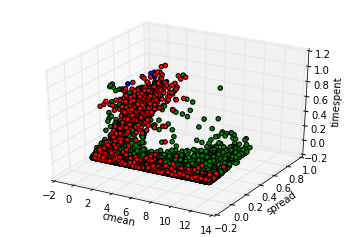

In [1060]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, i, target_name in zip("rgb", [-1, 0, 1], target_names):
    ax.scatter(X[Y == i, 0], X[Y == i, 1], X[Y == i, 2], c=c, label=target_name, alpha=1)
    
ax.set_xlabel('cmean')
ax.set_ylabel('spread')
ax.set_zlabel('timespent')

plt.show()

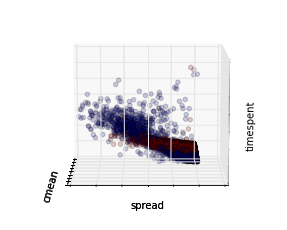

In [1145]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn.cluster import KMeans

np.random.seed(5)

centers = np.array([[0, 0.6, 0.4], [1,0.2,0]])
X = X_o
y = Y_o

estimators = {'k_means_iris_3': KMeans(n_clusters=2, init=centers)}


fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=10, azim=180)

    plt.cla()
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(np.float), alpha=0.2)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('cmean')
    ax.set_ylabel('spread')
    ax.set_zlabel('timespent')
    fignum = fignum + 1

plt.show()

In [837]:
X

array([[  9.42187500e+01,   3.13891695e+00,   8.10526316e-01,
          4.00331675e-01,   0.00000000e+00],
       [  8.33333333e-02,   1.80000000e+01,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00],
       [  1.04166667e-02,   1.50000000e+01,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.64583333e+00,   2.20000000e+01,   5.00000000e-01,
          1.00000000e+00,   0.00000000e+00],
       [  1.04166667e-02,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00],
       [  1.14583333e-01,   1.06754797e+01,   1.00000000e+00,
          2.72727273e-01,   0.00000000e+00]])

In [708]:
filter(lambda x: x['span'] > 20, sorted(statelist, key=lambda x: x['timespent'], reverse=True))

[{'campus': False,
  'cmean': 1.1030803138924214,
  'dorm': False,
  'label': 1.0,
  'loca_center': array([ 55.77704446,  12.52169957]),
  'span': 332.85416666666669,
  'spread': 0.5285285285285285,
  'timespent': 0.32718908430869376,
  'y': -1},
 {'campus': False,
  'cmean': 22.266755710959167,
  'dorm': False,
  'label': 2.0,
  'loca_center': array([ 55.58462767,  12.32223578]),
  'span': 332.03125,
  'spread': 0.26426426426426425,
  'timespent': 0.13418039215686275,
  'y': 0},
 {'campus': False,
  'cmean': 5.0848551195921372,
  'dorm': 'ostenf',
  'label': 0.0,
  'loca_center': array([ 55.78846821,  12.53262722]),
  'span': 267.98958333333331,
  'spread': 0.06716417910447761,
  'timespent': 0.02810277140747075,
  'y': -1},
 {'campus': True,
  'cmean': 8.8335722173466529,
  'dorm': False,
  'label': 20.0,
  'loca_center': array([ 55.78495987,  12.51976305]),
  'span': 86.0,
  'spread': 0.2988505747126437,
  'timespent': 0.022286821705426358,
  'y': 0},
 {'campus': True,
  'cmean': 10

In [592]:
def simple_time_zone_converter(time, longitude):
    return np.floor((longitude+7.5)/15)
        
        

1

In [644]:
for s in statelist:
    if s['cmean'] < 6:
        print s

{'state': 1.0, 'spread': 0.8105263157894737, 'span': 94.0, 'cmean': 3.1389169532018695, 'dorm': False, 'timespent': 0.84860557768924305, 'loca_center': array([  32.76292409, -117.06241145]), 'campus': False}
{'state': 11.0, 'spread': 0.6280487804878049, 'span': 163.1875, 'cmean': 1.1176215824572013, 'dorm': 'villum', 'timespent': 0.69130998702983137, 'loca_center': array([ 55.7843556 ,  12.52512245]), 'campus': False}
{'state': 12.0, 'spread': 0.1724137931034483, 'span': 144.0625, 'cmean': 4.6405337649390477, 'dorm': False, 'timespent': 0.11078834017830312, 'loca_center': array([ 55.64315013,  11.95526286]), 'campus': False}


0.196966373475
12807900
1.53785065057e-08


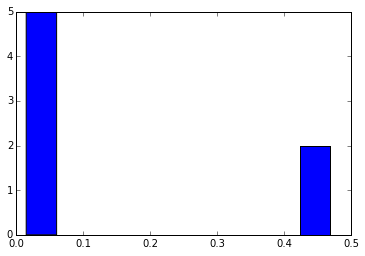

In [649]:
x = [i['timespent'] for i in sorted(statelist, key=lambda x: x['spread'], reverse=True)]
plt.hist(x)
#plt.xlim([u_t0,u_tt])
print np.std(x)
print u_tt-u_t0
print np.std(x)/(u_tt-u_t0)

In [559]:
def spread(timestamps, timerange):
    """Measures what fraction of days this location was measured"""
    bins = range(timerange/86400+1)
    vals = (np.array(timestamps)-timestamps[0])/86400
    hist = Counter(np.digitize(vals,bins))
    
    return len(hist) * 1.0 / len(bins)

In [532]:
spread(time_spre,u_tt-u_t0)

1.0

In [533]:
len(time_spre)

360

In [232]:
x = []
for u, locs in user_states_time_dist.items():
    for loc, time_dist in locs.items():
        x.append(circmean(time_dist))

In [297]:
x

array([  1.41046920e+09])

(array([ 34.,  22.,  17.,   3.,   3.,   3.,   2.,   1.,   1.,   2.,   4.,
          2.,   3.,   1.,   0.,   3.,   2.,   2.,   2.,   0.,   2.,   4.,
          9.,  29.]),
 array([  1.07316678e-02,   1.00762925e+00,   2.00452683e+00,
          3.00142441e+00,   3.99832199e+00,   4.99521957e+00,
          5.99211715e+00,   6.98901473e+00,   7.98591231e+00,
          8.98280989e+00,   9.97970747e+00,   1.09766050e+01,
          1.19735026e+01,   1.29704002e+01,   1.39672978e+01,
          1.49641954e+01,   1.59610929e+01,   1.69579905e+01,
          1.79548881e+01,   1.89517857e+01,   1.99486833e+01,
          2.09455808e+01,   2.19424784e+01,   2.29393760e+01,
          2.39362736e+01]),
 <a list of 24 Patch objects>)

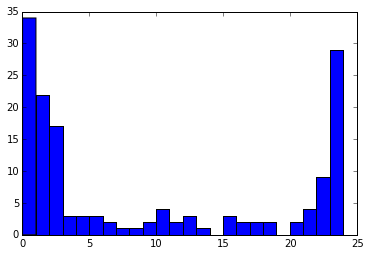

In [233]:
plt.hist(x,bins=24)

In [234]:
#np.array(df_stop_locations[df_stop_locations['user'] == 10][['lat','lon']])

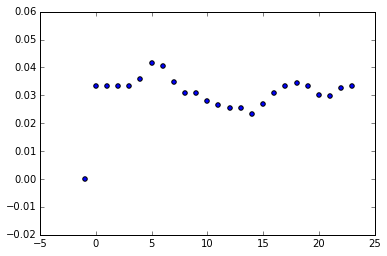

In [235]:
x = [i[0] for i in time_dist.items()]
y = [i[1] for i in time_dist.items()]
plt.scatter(x,y)


In [393]:
pd.DataFrame(np.array(X_u))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000868,0.001735,0.000868,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001735,0.001735,0.001735,0.001735,0.000868,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000434,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.001302,0.001735,0.001735,0.001735,0.001735,0.001735,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.024295,0.024295,0.024295,0.024295,0.026030,0.026030,0.023861,0.014751,0.008677,0.009544,...,0.006941,0.008243,0.016052,0.021258,0.020824,0.023861,0.024295,0.024295,0.024295,0.024295
7,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.002169,...,0.005206,0.005206,0.004772,0.003471,0.001302,0.002169,0.002169,0.003471,0.003471,0.003471
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000434,0.005206,0.016920,0.016052,...,0.012581,0.011280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [387]:
time_hist

defaultdict(<type 'int'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0004338394793926247, 7: 0.005206073752711497, 8: 0.016919739696312365, 9: 0.016052060737527116, 10: 0.009544468546637744, 11: 0.0013015184381778742, 12: 0.011713665943600867, 13: 0.011713665943600867, 14: 0.012581344902386117, 15: 0.011279826464208243, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, -1: 0.0})

In [634]:
if 10 < 15 < 20:
    print 1

1


In [363]:
tmp['delta'] = tmp.departure - tmp.arrival

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [645]:
sum([True,True,False])

2

In [35]:
print dt.fromtimestamp(1388615400  )
print dt.fromtimestamp(1388668500  )
print dt.fromtimestamp(1388619000)

2014-01-01 22:30:00
2014-01-02 13:15:00
2014-01-01 23:30:00


In [13]:
df_stop_locations

,arrival,departure,label,lat,lon,timestamp,user
0,1388538000,1388603700,1,55.744777,12.546418,1388541600000,784
1,1388605500,1388614500,29,55.711430,12.565539,1388609100000,784
2,1388615400,1388668500,1,55.744776,12.546420,1388619000000,784
3,1388669400,1388671200,23,55.745909,12.540880,1388673000000,784
4,1388672100,1388687400,1,55.744777,12.546417,1388675700000,784
5,1388690100,1388762100,1,55.744725,12.546381,1388693700000,784
6,1388765700,1388824200,1,55.744777,12.546420,1388769300000,784
7,1388826000,1388829600,56,55.810956,12.514193,1388829600000,784
8,1388835000,1388837700,20,55.717446,12.442254,1388838600000,784
9,1388840400,1388842200,43,55.676556,12.547488,1388844000000,784


In [78]:
sample = {'arrival': 1389381300.0,
  'coordinates': (55.643132199999997, 11.955254999999999),
  'duration': 3600.0}

In [328]:
def bin_24(start, duration):
    bins = [h*3600 for h in range(24)]
    vals = [x%86400 for x in xrange(int(start),int(start+duration),1)]
    return dict((k-1,v) for k,v in Counter(np.digitize(vals,bins)).items())

In [330]:
print bin_24(sample['arrival'], sample['duration'])

{19: 2700, 20: 900}


In [322]:
print dt.fromtimestamp(sample['arrival'])
print dt.fromtimestamp(sample['arrival']+sample['duration'])

2014-01-10 19:15:00
2014-01-10 20:15:00


In [250]:
print dt.fromtimestamp(start)
print dt.fromtimestamp(0)

2014-01-02 00:53:20
1970-01-01 00:00:00


In [305]:
start, duration = 1388624000, 9000
(start%86400/3600*3600 + 3600) - start%86400

400

In [306]:
inp = [x%86400 for x in xrange(start,start+duration,1)]

In [307]:
bins = [h*3600 for h in range(24)]

In [308]:
Counter(np.digitize(inp,bins))

Counter({2: 3600, 3: 3600, 4: 1400, 1: 400})

In [303]:
from collections import Counter